In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.api import AutoReg

C:\Users\miche\anaconda3\lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
df_patient_hr = pd.read_excel('patient_hr_1.xlsx')
df_patient_hr

,TIMESTAMP,HRV
0,2009-03-04 11:00:00.000,2294.92
1,2009-03-04 11:00:02.295,631.84
2,2009-03-04 11:00:02.927,624.02
3,2009-03-04 11:00:03.551,636.72
4,2009-03-04 11:00:04.188,625.98
...,...,...
107469,2009-03-05 08:07:30.918,671.88
107470,2009-03-05 08:07:31.590,669.92
107471,2009-03-05 08:07:32.260,670.90
107472,2009-03-05 08:07:32.931,662.11


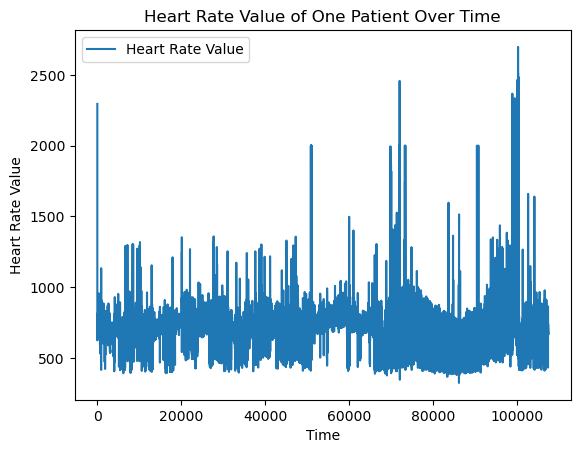

In [3]:
# visualize the time series
plt.plot(df_patient_hr['HRV'], label='Heart Rate Value')
plt.xlabel('Time')
plt.ylabel('Heart Rate Value')
plt.legend()
plt.title('Heart Rate Value of One Patient Over Time')
plt.show();

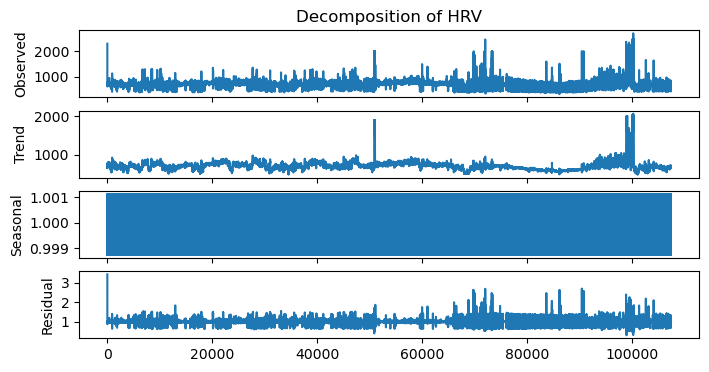

In [4]:
# Checking out the decompositions

# setting the period makes the assumption that the seasonal trend should happen every "period" units (e.g. 10 years, or 5 days)
# can change model='multiplicative' to see if there's a change in seasonal trend
decomp1 = seasonal_decompose(df_patient_hr['HRV'], period=10, model='multiplicative', extrapolate_trend='freq')
# decomp2 = seasonal_decompose(data['Close'], period=5, model='additive', extrapolate_trend='freq')

fig, ax = plt.subplots(ncols=1, nrows=4, sharex=True, figsize=(8,4))
ax[0].set_title('Decomposition of HRV')
decomp1.observed.plot(ax=ax[0], legend=False)
ax[0].set_ylabel('Observed')

decomp1.trend.plot(ax=ax[1], legend=False)
ax[1].set_ylabel('Trend')

decomp1.seasonal.plot(ax=ax[2], legend=False)
ax[2].set_ylabel('Seasonal')

decomp1.resid.plot(ax=ax[3], legend=False)
ax[3].set_ylabel('Residual')

plt.show();

- no patterns in residual

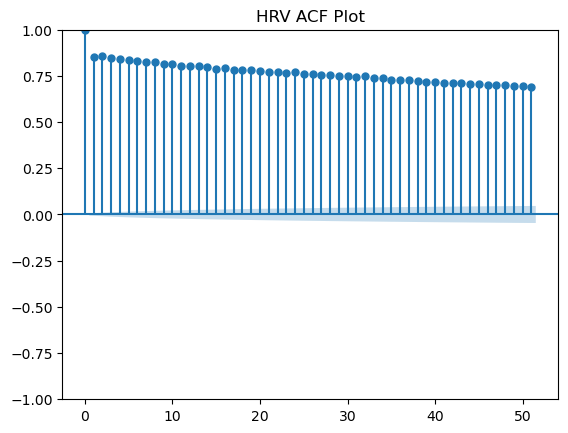

In [5]:
# Autocorrelation Function
# This is used to determine the appropriate lag

# use the original data
series = df_patient_hr['HRV']
plot_acf(series, title = 'HRV ACF Plot')
plt.show();
# Looks like even up to a lag of 10 could provide significant information about the ensuing years

- AR model may be better

In [6]:
# Split into training and test sets; since we are looking at time series; we are NOT randomly splitting the data
# Take instead the first 80% for the training, then we'll see if the first 80% of MLB history can be used to predict the next 20%
train_size = int(.8 * len(df_patient_hr))
train_data = df_patient_hr[:train_size]
test_data = df_patient_hr[train_size:]

# put the y feature (the current SO9) in arrays
y_train = np.array(train_data['HRV']).reshape(-1,1)
y_test = np.array(test_data['HRV']).reshape(-1,1)

In [7]:
# fit using packages (should do this manually if AR model is good)
# Using statsmodels AutoReg function

ar_model = AutoReg(y_train, lags=50, trend='n') # the default is to add an intercept (or, trend='c'), 
# using trend='n' is more in line with traditional AR(p) models, but may result in a nonstationary model
ar_results = ar_model.fit()

In [8]:
ar_results.params
ar_results.roots

array([ 1.00005878e+00-0.j        ,  1.08632433e+00-0.14868466j,
        1.08632433e+00+0.14868466j,  1.08787070e+00-0.2978849j ,
        1.08787070e+00+0.2978849j ,  1.04532163e+00-0.40459367j,
        1.04532163e+00+0.40459367j,  9.65190505e-01-0.5195094j ,
        9.65190505e-01+0.5195094j ,  7.39466987e-01-0.73913861j,
        7.39466987e-01+0.73913861j,  8.71155092e-01-0.63357324j,
        8.71155092e-01+0.63357324j,  1.39192653e+00-0.j        ,
        6.44184159e-01-0.86337752j,  6.44184159e-01+0.86337752j,
        5.31051652e-01-0.9353474j ,  5.31051652e-01+0.9353474j ,
        4.00514024e-01-0.99678634j,  4.00514024e-01+0.99678634j,
        2.74887683e-01-1.04920409j,  2.74887683e-01+1.04920409j,
        1.59642369e-01-1.0604102j ,  1.59642369e-01+1.0604102j ,
       -1.05581087e-03-1.03605215j, -1.05581087e-03+1.03605215j,
       -1.62930976e-01-1.04695091j, -1.62930976e-01+1.04695091j,
       -3.12451706e-01-1.03453784j, -3.12451706e-01+1.03453784j,
       -4.36369848e-01-1.

In [9]:
# the predictions
ar_pred = ar_results.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
pred_data = pd.DataFrame({'Time': test_data.index, 'pred HRV': ar_pred.flatten()})
pred_data.set_index('Time', inplace = True)
pred_data.head()

,pred HRV
Time,
85979,568.834720
85980,569.080537
85981,568.351562
85982,568.815937
85983,569.306362


In [10]:
print(len(pred_data))
print(len(y_test))

21495
21495


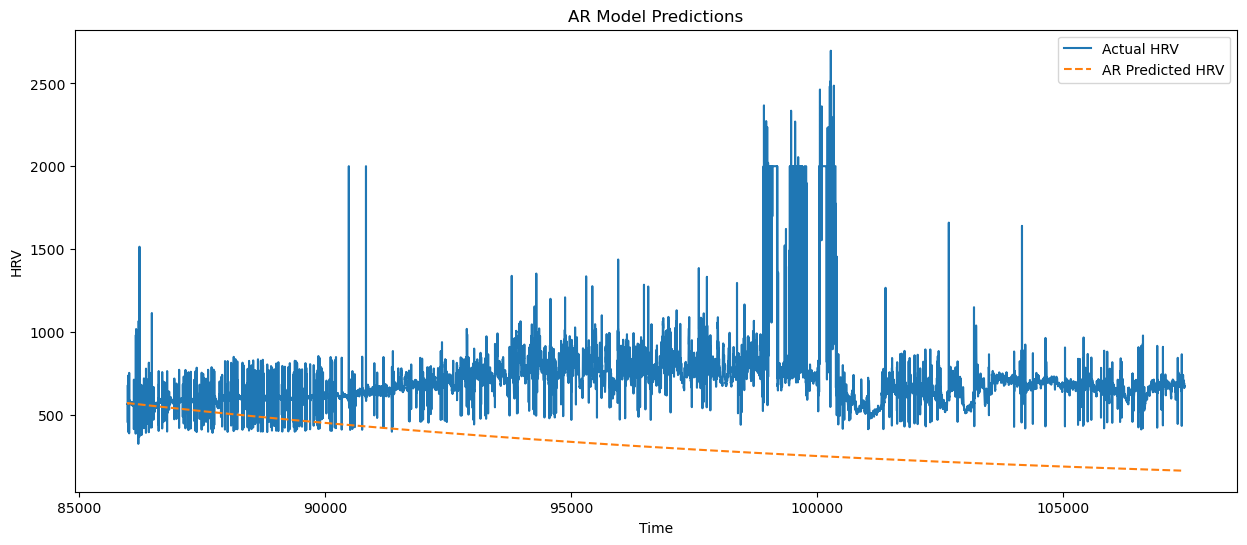

In [11]:
# make the plot
plt.figure(figsize=(15, 6))

plt.plot(test_data['HRV'], label = 'Actual HRV')
plt.plot(pred_data['pred HRV'], label = 'AR Predicted HRV', linestyle = '--')
plt.xlabel('Time')
plt.ylabel('HRV')
plt.legend()
plt.title('AR Model Predictions')
plt.show();

In [12]:
# We can also look at the MAE and RMSE, though these are only useful when comparing against other models
from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, pred_data)
rmse = np.sqrt(mean_squared_error(y_test, pred_data))
print(f'Mean Absolute Error: {mae:.2f}')
print(f'Root Mean Squared Error: {rmse:.2f}')

Mean Absolute Error: 397.84
Root Mean Squared Error: 490.56


In [20]:
# For AR(p), you would do ARIMA(series, order=(p, 0, 0))
# For MA(q), you would do ARIMA(series, order=(0, 0, q))
# For ARIMA(p,q), it's ARIMA(series, order=(p, 0, q))
# And for ARIMA(p, d, q), it's ARIMA(series, order=(p,d,q))
# though you should investigate a little bit more outside of class just what combining them entails before trusting
# here's the docs: https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html
# CHANGE NUMBER HERE
ma_model = ARIMA(y_train, order=(0, 0, 50)) # here is the MA(1) model
ma_results = ma_model.fit()

#summary of the model
ma_results.summary()
# Interpretation: coef. of the constant is 3.8981 which works as the mean of the dataset 
# coefficient of the noise value ma.L1 is .7172, but the P>|z| tells us that this has a significant impact on the output
# (note, if we used the differenced data, the constant is no longer interpretable as the mean/level of the series)

KeyboardInterrupt: 

In [ ]:
# getting the predictions works the same as in AR(p)
# but note that MA(q) models are even worse at long-term broadcasting
# and that everything after order q=1 is simply predicted at the mean
ma_pred = ma_results.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
pred_data = pd.DataFrame({'Time': test_data.index, 'pred HRV': ma_pred.flatten()})
pred_data.set_index('Time', inplace = True)
pred_data.head()

In [ ]:
plt.plot(test_data['HRV'], label = 'Actual HRV')
plt.plot(pred_data['pred HRV'], label = 'MA Predicted HRV', linestyle = '--')
plt.xlabel('Time')
plt.ylabel('HRV')
plt.legend()
plt.title('MA Model Predictions')
plt.show();

In [16]:
# For AR(p), you would do ARIMA(series, order=(p, 0, 0))
# For MA(q), you would do ARIMA(series, order=(0, 0, q))
# For ARIMA(p,q), it's ARIMA(series, order=(p, 0, q))
# And for ARIMA(p, d, q), it's ARIMA(series, order=(p,d,q))
# though you should investigate a little bit more outside of class just what combining them entails before trusting
# here's the docs: https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html
# CHANGE NUMBER HERE
arima_model = ARIMA(y_train, order=(50, 0, 50)) # here is the MA(1) model
arima_results = ma_model.fit()

#summary of the model
arima_results.summary()
# Interpretation: coef. of the constant is 3.8981 which works as the mean of the dataset 
# coefficient of the noise value ma.L1 is .7172, but the P>|z| tells us that this has a significant impact on the output
# (note, if we used the differenced data, the constant is no longer interpretable as the mean/level of the series)

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                85979
Model:                 ARIMA(0, 0, 5)   Log Likelihood             -470537.524
Date:                Mon, 31 Mar 2025   AIC                         941089.048
Time:                        19:34:40   BIC                         941154.581
Sample:                             0   HQIC                        941109.071
                              - 85979                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        704.6718      0.689   1023.163      0.000     703.322     706.022
ma.L1          0.4430      0.001    717.418      0.000       0.442       0.444
ma.L2          0.5219      0.001    651.554      0.000       0.520       0.523
ma.L3          0.4670      0.001    443.000      0.000       0.465       0.469
ma.L4          0.3632      0.001    354.526      0.000       0.361       0.365
ma.L5          0.2785      0.001    273.234      0.000       0.277       0.281
sigma2      3319.2975      2.769   1198.531      0.000    3313.869    3324.726
===================================================================================
Ljung-Box (L1) (Q):                 349.87   Jarque-Bera (JB):          28792371.18
Prob(Q):                              0.00   Prob(JB):                         0.00
Heteroskedasticity (H):               2.29   Skew:                             4.20
Prob(H) (two-sided):                  0.00   Kurtosis:                        92.26
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [17]:
# getting the predictions works the same as in AR(p)
# but note that MA(q) models are even worse at long-term broadcasting
# and that everything after order q=1 is simply predicted at the mean
arima_pred = arima_results.predict(start=len(train_data), end=len(train_data) + len(test_data) - 1)
pred_data = pd.DataFrame({'Time': test_data.index, 'pred HRV': arima_pred.flatten()})
pred_data.set_index('Time', inplace = True)
pred_data.head()

,pred HRV
Time,
85979,612.773619
85980,632.239698
85981,655.517192
85982,676.696179
85983,692.793538


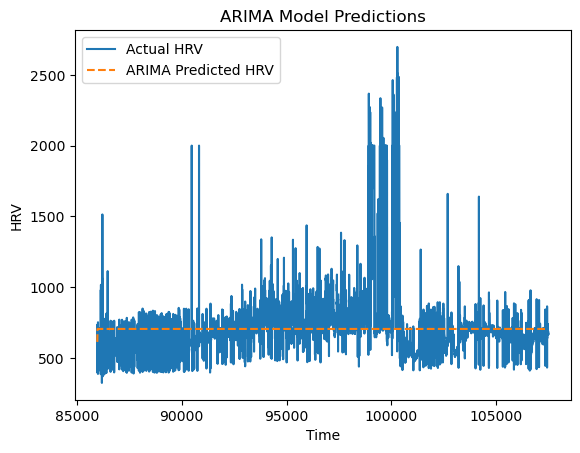

In [19]:
plt.plot(test_data['HRV'], label = 'Actual HRV')
plt.plot(pred_data['pred HRV'], label = 'ARIMA Predicted HRV', linestyle = '--')
plt.xlabel('Time')
plt.ylabel('HRV')
plt.legend()
plt.title('ARIMA Model Predictions')
plt.show();